In [1]:
import sys; print('Python %s on %s' % (sys.version, sys.platform))
sys.path.extend(['/home/tm/projects/Open_Close_GNN-1/'])

Python 3.10.12 (main, Mar 22 2024, 16:50:05) [GCC 11.4.0] on linux


In [2]:
import numpy as np
from scipy.stats import zscore

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, SubsetRandomSampler
from torch.optim import lr_scheduler


import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.model_selection import GroupKFold, train_test_split, GroupShuffleSplit

from tqdm import trange
from tqdm.notebook import tqdm

from transformers import TimeSeriesTransformerConfig, TimeSeriesTransformerForPrediction

In [3]:
from model.utils import device, train
from augmentation.train_loop import *
from augmentation.data_preparation import *


In [4]:
import os

import matplotlib.pyplot as plt
import numpy as np
import torch
from seaborn import heatmap
from sklearn.model_selection import GroupKFold
from torch.optim import lr_scheduler
from torch.utils.data import SubsetRandomSampler
from torch_geometric.loader import DataLoader

from tqdm.notebook import tqdm

from model.dataset import OpenCloseDataset
from model.gnn_model import GCN, GATv2
from model.utils import device, eval_epoch, train, train_epoch, load_data_and_groups

import pickle

In [5]:
closed_ihb = np.load('/data/Projects/OpenCloseIHB/closed_ihb.npy')
opened_ihb = np.load('/data/Projects/OpenCloseIHB/opened_ihb.npy')

closed = zscore(closed_ihb)
opened = zscore(opened_ihb)

closed = torch.tensor(closed, dtype=torch.float)
opened = torch.tensor(opened, dtype=torch.float)

print(closed.shape, opened.shape)

concat = torch.cat([closed, opened])

torch.Size([84, 120, 423]) torch.Size([84, 120, 423])


In [6]:
closed_ch = np.load("/data/Projects/OpenCloseChina/closed_china.npy")
opened_ch = np.load("/data/Projects/OpenCloseChina/opened_china.npy")

closed_ch = zscore(closed_ch, nan_policy='omit')
opened_ch = zscore(opened_ch, nan_policy='omit')

np.nan_to_num(closed_ch, copy=False)
np.nan_to_num(opened_ch, copy=False)

closed_ch = torch.tensor(closed_ch, dtype=torch.float)
opened_ch = torch.tensor(opened_ch, dtype=torch.float)

print(closed_ch.shape, opened_ch.shape)

# добавляю 2 нулевые серии просто потому, что у наших данных на 2 региона больше
closed_ch = torch.cat([closed_ch, torch.zeros(95, 240, 2)], dim=2)
opened_ch = torch.cat([opened_ch, torch.zeros(47, 240, 2)], dim=2)

torch.Size([95, 240, 421]) torch.Size([47, 240, 421])


In [7]:
abide = np.load('/data/Projects/ABIDE/train_abide.npy')
abide = zscore(abide)
abide = torch.tensor(abide, dtype=torch.float)
abide.shape

torch.Size([500, 120, 423])

In [8]:
def plot_aug(real, aug, sub, net):
    print(np.corrcoef(aug[sub][:, net], real[sub][:, net])[0, 1])
    plt.figure(figsize=(15, 5))
    plt.plot(real[sub][:, net], label='real')
    plt.plot(aug[sub][:, net], label='aug')
    plt.legend()
    plt.title(f'Augmented data');

In [9]:
from nilearn.connectome import ConnectivityMeasure

def fc_calc(data):
    con = ConnectivityMeasure(kind='correlation', standardize=False)
    fc_cl = con.fit_transform(data)
    for i in fc_cl:
        np.fill_diagonal(i, 0)
    return fc_cl


# augmentations

## transformer

In [12]:
# предсказание 1 точки по 20 предыдущим

context, predict = 20, 1
transformer_dataset = transformer_data(concat, context, predict)

batch_size = 64
transformer_train_loader = DataLoader(transformer_dataset, batch_size=batch_size)

In [13]:
lags_sequence = [1, 2, 3, 4, 5, 6, 7]
configuration = TimeSeriesTransformerConfig(prediction_length=predict,
                                            context_length=context - len(lags_sequence),
                                            input_size=423,
                                            num_time_features=1,
                                            lags_sequence=lags_sequence,
                                            num_parallel_samples=1,
                                            scaling='std',
                                            )

aug_model = TimeSeriesTransformerForPrediction(configuration)
aug_model.to(device())

optimizer = torch.optim.AdamW(aug_model.parameters(), lr=1e-3, betas=(0.7, 0.8), weight_decay=0.9)

In [ ]:
epochs = 100
scheduler = lr_scheduler.StepLR(optimizer, step_size=epochs//2, gamma=10, last_epoch=-1) 

aug_history = train_aug(aug_model, epochs, 
                        transformer_train_loader, None,
                        optimizer=optimizer, transformer=True, save_best=False, 
                        scheduler=None, criterion=None)

In [86]:
augments_per_sample = 1

aug_closed_1 = generate_data(closed, aug_model, 
                           context=context, predict=predict,
                           augments_per_sample=augments_per_sample)

aug_opened_1 = generate_data(opened, aug_model, 
                           context=context, predict=predict,
                           augments_per_sample=augments_per_sample)

#torch.save(aug_closed_1, '/data/Projects/fMRI_Augmentations/gen_data/ihb/trans_cl_1.pt')
#torch.save(aug_opened_1, '/data/Projects/fMRI_Augmentations/gen_data/ihb/trans_op_1.pt')

100%|██████████| 84/84 [00:34<00:00,  2.47it/s]


0.020100163028182152


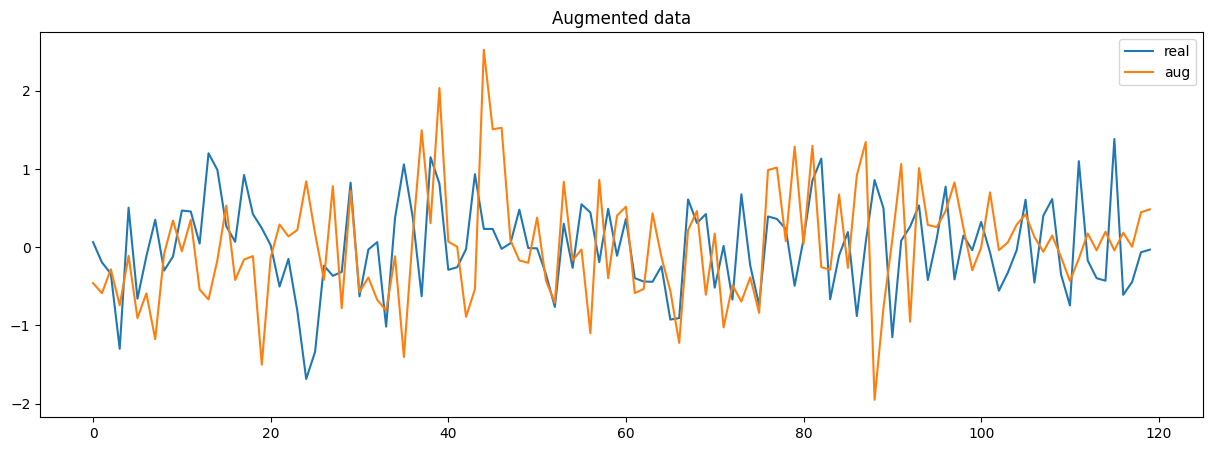

In [14]:
plot_aug(opened, aug_opened_1, sub=65, net=1)

## lstm

In [15]:
class LSTMGenerator(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTMGenerator, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out)
        return out

In [16]:
# lstm генерирует сразу всю серию для каждого роя

lstm = LSTMGenerator(423, 128, 2, 423).to(device())
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(lstm.parameters(), lr=0.003)

In [17]:
abide = np.load('/data/Projects/ABIDE/train_abide.npy')
abide = zscore(abide)
abide = torch.tensor(abide, dtype=torch.float)

lstm_abide_dataset = TensorDataset(abide.to(device()), abide.to(device()))

val_idx = np.random.choice(np.arange(len(abide)), 10) 
train_idx = np.setdiff1d(np.arange(len(abide)), val_idx)

batch_size = 64
lstm_abide_train_loader = DataLoader(lstm_abide_dataset, batch_size=batch_size, sampler=SubsetRandomSampler(train_idx))
lstm_abide_val_loader = DataLoader(lstm_abide_dataset, batch_size=batch_size, sampler=SubsetRandomSampler(val_idx))

In [18]:
lstm_dataset = TensorDataset(concat.to(device()), concat.to(device()))

val_idx = np.random.choice(np.arange(len(opened)), 10) 
train_idx = np.setdiff1d(np.arange(len(opened)), val_idx)

batch_size = 64
lstm_train_loader = DataLoader(lstm_dataset, batch_size=batch_size, sampler=SubsetRandomSampler(train_idx))
lstm_val_loader = DataLoader(lstm_dataset, batch_size=batch_size, sampler=SubsetRandomSampler(val_idx))

In [19]:
h = train_aug(lstm, 30, lstm_abide_train_loader, lstm_abide_val_loader, criterion, optimizer)

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 001, Train Loss: 0.8220, Test Loss 0.7264
Epoch: 002, Train Loss: 0.7699, Test Loss 0.6782
Epoch: 003, Train Loss: 0.7041, Test Loss 0.6297
Epoch: 004, Train Loss: 0.6731, Test Loss 0.5920
Epoch: 005, Train Loss: 0.6387, Test Loss 0.5644
Epoch: 006, Train Loss: 0.6125, Test Loss 0.5433
Epoch: 007, Train Loss: 0.5953, Test Loss 0.5252
Epoch: 008, Train Loss: 0.5712, Test Loss 0.5040
Epoch: 009, Train Loss: 0.5543, Test Loss 0.4870
Epoch: 010, Train Loss: 0.5363, Test Loss 0.4744
Epoch: 011, Train Loss: 0.5209, Test Loss 0.4601
Epoch: 012, Train Loss: 0.5121, Test Loss 0.4492
Epoch: 013, Train Loss: 0.4947, Test Loss 0.4386
Epoch: 014, Train Loss: 0.4796, Test Loss 0.4275
Epoch: 015, Train Loss: 0.4745, Test Loss 0.4198
Epoch: 016, Train Loss: 0.4587, Test Loss 0.4104
Epoch: 017, Train Loss: 0.4567, Test Loss 0.4030
Epoch: 018, Train Loss: 0.4464, Test Loss 0.3974
Epoch: 019, Train Loss: 0.4376, Test Loss 0.3904
Epoch: 020, Train Loss: 0.4328, Test Loss 0.3825
Epoch: 021, Train Lo

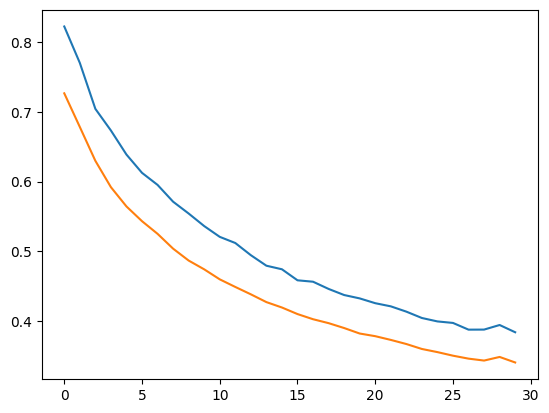

In [20]:
t, v = zip(*h)

plt.plot(t)
plt.plot(v)

In [21]:
generated_series_cl = []
lstm.eval()
with torch.no_grad():
    for i in closed:
        sample_input = i.to(device()).unsqueeze(0)
        generated_series_cl.append(lstm(sample_input).squeeze(0).cpu().numpy())

#torch.save(generated_series_cl, '/data/Projects/fMRI_Augmentations/gen_data/ihb/lstm_cl.pt')

In [22]:
generated_series_op = []
lstm.eval()
with torch.no_grad():
    for i in opened:
        sample_input = i.to(device()).unsqueeze(0)
        generated_series_op.append(lstm(sample_input).squeeze(0).cpu().numpy())

#torch.save(generated_series_op, '/data/Projects/fMRI_Augmentations/gen_data/ihb/lstm_op.pt')

In [27]:
generated_series_cl_ch = []
lstm.eval()
with torch.no_grad():
    for i in closed_ch:
        sample_input = i.to(device()).unsqueeze(0)
        generated_series_cl_ch.append(lstm(sample_input).squeeze(0).cpu().numpy())

#torch.save(generated_series_cl_ch, '/data/Projects/fMRI_Augmentations/gen_data/china/lstm_cl.pt')

In [28]:
generated_series_op_ch = []
lstm.eval()
with torch.no_grad():
    for i in opened:
        sample_input = i.to(device()).unsqueeze(0)
        generated_series_op_ch.append(lstm(sample_input).squeeze(0).cpu().numpy())

#torch.save(generated_series_op_ch, '/data/Projects/fMRI_Augmentations/gen_data/china/lstm_op.pt')

0.8252688732284051


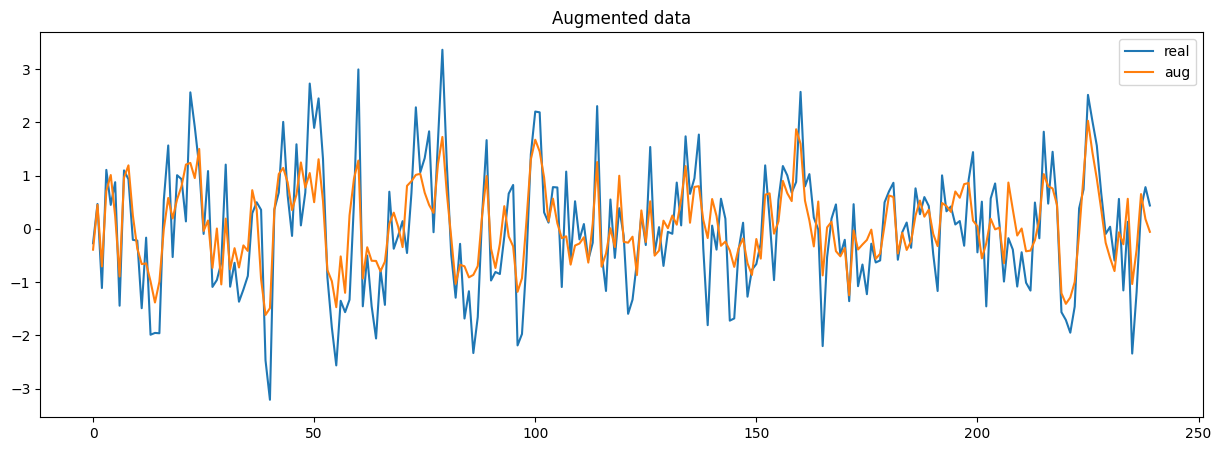

In [25]:
plot_aug(closed_ch, generated_series_cl_ch, 10, 8)

# model training

-

In [195]:
fc_cl = fc_calc(closed.numpy())
fc_op = fc_calc(opened.numpy())

full_dataset = OpenCloseDataset(datafolder='../data/', # dir where the processed files will be stored
                                open_file=fc_op, # data should be np.array of size (n_subjects, n_rois, n_rois)
                                close_file=fc_cl, # an array for closed and opened eyes
                                reload=True, # whether you want to reload already processed graphs
                                k_degree=15) # k degree

Processing...
Done!


In [13]:
fc_cl = fc_calc(closed_ch.numpy())
fc_op = fc_calc(opened_ch.numpy())

china_dataset = OpenCloseDataset(datafolder='../data/lstm_china', # dir where the processed files will be stored
                                open_file=fc_op, # data should be np.array of size (n_subjects, n_rois, n_rois)
                                close_file=fc_cl, # an array for closed and opened eyes
                                reload=True, # whether you want to reload already processed graphs
                                k_degree=15) # k degree



groups = np.concatenate([
            np.arange(opened_ch.shape[0], dtype=int), 
            np.arange(closed_ch.shape[0], dtype=int), 
            ])

labels = [china_dataset[i].y for i in range(len(china_dataset))]


gkf = GroupKFold()
train_index, val_test_index = next(iter(gkf.split(labels, groups=groups)))

train_loader_ch = DataLoader(china_dataset, batch_size=32, shuffle=False, sampler=SubsetRandomSampler(train_index))
val_loader_ch = DataLoader(china_dataset, batch_size=32, shuffle=False, sampler=SubsetRandomSampler(val_test_index))

Processing...
Done!


In [177]:
aug_closed_1 = torch.load('/data/Projects/fMRI_Augmentations/gen_data/ihb/lstm_cl.pt')
aug_opened_1 = torch.load('/data/Projects/fMRI_Augmentations/gen_data/ihb/lstm_op.pt')

In [178]:
gen_cl = np.concatenate([closed.numpy(), aug_closed_1])
gen_op = np.concatenate([opened.numpy(), aug_opened_1])


fc_op = fc_calc(gen_cl)
fc_cl = fc_calc(gen_op)

full_dataset = OpenCloseDataset(datafolder='../data/trans3_ihb', # dir where the processed files will be stored
                                open_file=fc_op, # data should be np.array of size (n_subjects, n_rois, n_rois)
                                close_file=fc_cl, # an array for closed and opened eyes
                                reload=True, # whether you want to reload already processed graphs
                                k_degree=15) # k degree

Processing...
Done!


In [196]:
n = 10

groups = np.concatenate([
            np.arange(opened.shape[0], dtype=int), 
            #np.arange(opened.shape[0], dtype=int), 
            #np.array([[i] * n for i in range(opened.shape[0], opened.shape[0] + opened.shape[0])]).flatten(), 
            #np.arange(closed.shape[0], dtype=int), 
            np.arange(closed.shape[0], dtype=int), 
            #np.array([[i] * n for i in range(closed.shape[0], closed.shape[0] + closed.shape[0])]).flatten()
            ])

labels = [full_dataset[i].y for i in range(len(full_dataset))]


gkf = GroupShuffleSplit()
train_index, val_test_index = next(iter(gkf.split(labels, groups=groups)))

train_loader = DataLoader(full_dataset, batch_size=32, shuffle=False, sampler=SubsetRandomSampler(train_index))
val_loader = DataLoader(full_dataset, batch_size=32, shuffle=False, sampler=SubsetRandomSampler(val_test_index))

In [220]:
model = GCN(full_dataset.num_features, channels=[32, 8], dropout=0.2).to(device())
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.02)
loss = torch.nn.CrossEntropyLoss()
epochs = 60
scheduler = lr_scheduler.StepLR(optimizer, step_size=epochs//2, gamma=0.1, last_epoch=-1)
sum(p.numel() for p in model.parameters())

13914

In [208]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.2)
history = train(model, epochs, train_loader, val_loader, loss, optimizer, 
                scheduler=None, save_best=True, path_to_save='..whatever.pt')

  0%|          | 0/60 [00:00<?, ?it/s]

Epoch: 001, Train Loss: 0.6993, Test Loss 0.7143, Train Acc: 0.5542, Test Acc: 0.5000
Test precision: 0.5000, Test recall: 1.0000, Test F1: 0.6667
Epoch: 002, Train Loss: 0.7212, Test Loss 0.7251, Train Acc: 0.5000, Test Acc: 0.5000
Test precision: 0.5000, Test recall: 1.0000, Test F1: 0.6667
Epoch: 003, Train Loss: 0.6989, Test Loss 0.7328, Train Acc: 0.5542, Test Acc: 0.5000
Test precision: 0.5000, Test recall: 1.0000, Test F1: 0.6667
Epoch: 004, Train Loss: 0.7133, Test Loss 0.6078, Train Acc: 0.4875, Test Acc: 0.7188
Test precision: 0.7258, Test recall: 0.9667, Test F1: 0.8043
Epoch: 005, Train Loss: 0.7270, Test Loss 0.8198, Train Acc: 0.4667, Test Acc: 0.2656
Test precision: 0.2667, Test recall: 0.4706, Test F1: 0.3404
Epoch: 006, Train Loss: 0.6999, Test Loss 0.6486, Train Acc: 0.4812, Test Acc: 0.5312
Test precision: 0.7593, Test recall: 0.7167, Test F1: 0.6667
Epoch: 007, Train Loss: 0.7008, Test Loss 0.6650, Train Acc: 0.4812, Test Acc: 0.7656
Test precision: 0.7593, Test rec

In [137]:
model.load_state_dict(torch.load('..whatever.pt'))

<All keys matched successfully>

In [221]:

h = train(model, 60, train_loader_ch, val_loader_ch, loss, optimizer, 
                scheduler=None, save_best=True, path_to_save='..whatever_ch.pt')

  0%|          | 0/60 [00:00<?, ?it/s]

Epoch: 001, Train Loss: 0.8056, Test Loss 0.8097, Train Acc: 0.3373, Test Acc: 0.3448
Test precision: 0.3448, Test recall: 1.0000, Test F1: 0.5128
Epoch: 002, Train Loss: 0.7977, Test Loss 0.8029, Train Acc: 0.3304, Test Acc: 0.3448
Test precision: 0.3448, Test recall: 1.0000, Test F1: 0.5128
Epoch: 003, Train Loss: 0.7896, Test Loss 0.7953, Train Acc: 0.3166, Test Acc: 0.3448
Test precision: 0.3448, Test recall: 1.0000, Test F1: 0.5128
Epoch: 004, Train Loss: 0.7719, Test Loss 0.7878, Train Acc: 0.3235, Test Acc: 0.3448
Test precision: 0.3448, Test recall: 1.0000, Test F1: 0.5128
Epoch: 005, Train Loss: 0.7605, Test Loss 0.7815, Train Acc: 0.3313, Test Acc: 0.3448
Test precision: 0.3448, Test recall: 1.0000, Test F1: 0.5128
Epoch: 006, Train Loss: 0.7503, Test Loss 0.7774, Train Acc: 0.3548, Test Acc: 0.3448
Test precision: 0.3448, Test recall: 1.0000, Test F1: 0.5128
Epoch: 007, Train Loss: 0.7229, Test Loss 0.7729, Train Acc: 0.4196, Test Acc: 0.3103
Test precision: 0.3214, Test rec

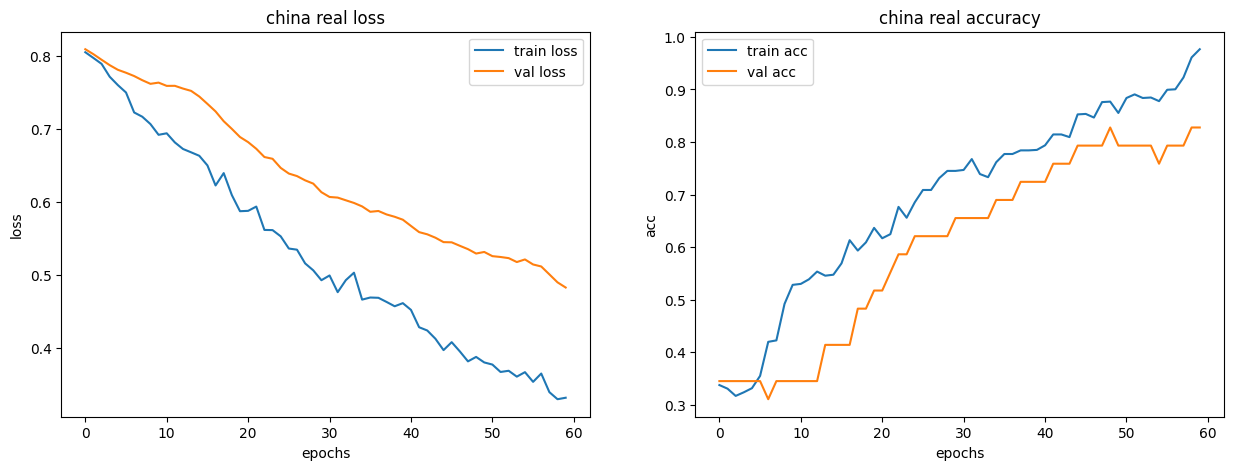

In [222]:
train_loss, val_loss, train_acc, test_acc = zip(*h)

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].plot(train_loss, label='train loss')
ax[0].plot(val_loss, label='val loss')
ax[0].set_xlabel('epochs')
ax[0].set_ylabel('loss')
ax[0].set_title('china real loss')
ax[0].legend()

ax[1].plot(train_acc, label='train acc')
ax[1].plot(test_acc, label='val acc')
ax[1].set_xlabel('epochs')
ax[1].set_ylabel('acc')
ax[1].set_title('china real accuracy')
ax[1].legend();

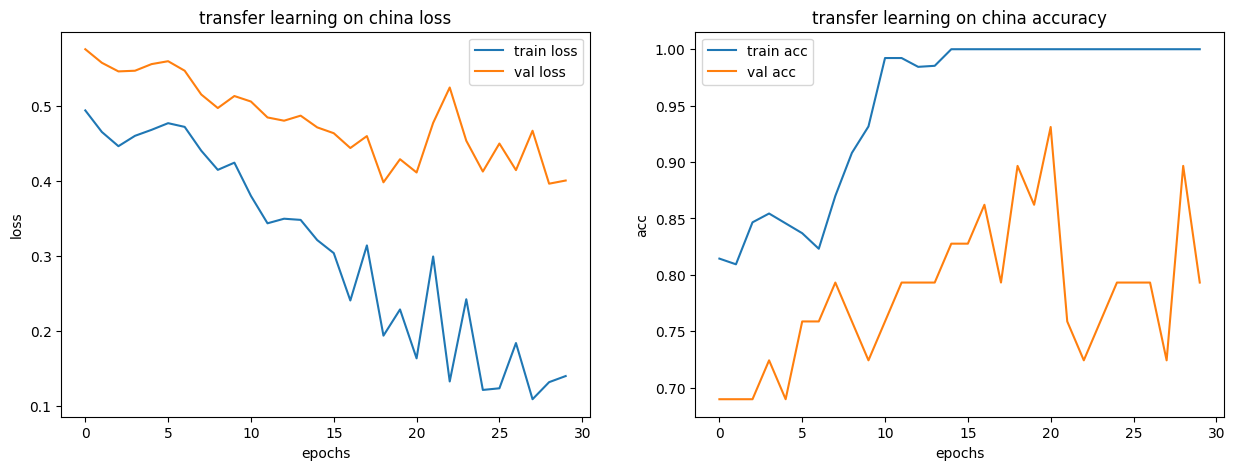

In [213]:
train_loss, val_loss, train_acc, test_acc = zip(*h)

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].plot(train_loss, label='train loss')
ax[0].plot(val_loss, label='val loss')
ax[0].set_xlabel('epochs')
ax[0].set_ylabel('loss')
ax[0].set_title('transfer learning on china loss')
ax[0].legend()

ax[1].plot(train_acc, label='train acc')
ax[1].plot(test_acc, label='val acc')
ax[1].set_xlabel('epochs')
ax[1].set_ylabel('acc')
ax[1].set_title('transfer learning on china accuracy')
ax[1].legend();

In [217]:
eval_epoch(val_loader, model, loss)[1]

0.78125

In [216]:
eval_epoch(val_loader_ch, model, loss)[1]

0.8965517

# см

In [117]:
def cv(chan, n_epochs, lr, dp, wd, crossval_dataset, groups, labels, n_splits=5, rs=0):
    skf = GroupShuffleSplit(n_splits=n_splits, test_size=0.3, random_state=rs) #GroupKFold(n_splits=n_splits)
    eval_metrics = np.zeros((skf.n_splits, 3))
    #labels = torch.Tensor([i[1] for i in crossval_dataset])

    for n_fold, (train_idx, test_idx) in tqdm(enumerate(skf.split(labels, groups=groups))):
        best_val_loss = 1000
        torch.cuda.empty_cache()
        model = GCN(423, channels=chan, dropout=dp).to(device())
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
        criterion = torch.nn.CrossEntropyLoss()
        #criterion = nn.BCELoss()
        scheduler = lr_scheduler.StepLR(optimizer, step_size=n_epochs//2, gamma=0.1, last_epoch=-1)

        train_loader_cv = DataLoader(crossval_dataset, batch_size=32, shuffle=False, sampler=SubsetRandomSampler(train_idx))
        test_loader_cv = DataLoader(crossval_dataset, batch_size=32, shuffle=False, sampler=SubsetRandomSampler(test_idx))
        min_v_loss = np.inf
        print('==========', n_fold, '==========')
        acc = []
        for epoch in range(n_epochs):
            train_epoch(train_loader_cv, model, criterion, optimizer)
            train_loss, train_acc, _, _, _ = eval_epoch(train_loader_cv, model, criterion)
            val_loss, test_acc, _, _, _ = eval_epoch(test_loader_cv, model, criterion)
            
            #
            #scheduler.step()
            if epoch % 5 == 0:
                print(f'Epoch: {epoch:03d}, Train Loss: {train_loss:.4f}, Test Loss {val_loss:.4f},',
                      f'Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

            acc.append(test_acc)
            
            if min_v_loss > val_loss:
                min_v_loss = val_loss
                best_test_acc = test_acc
            
        if best_val_loss > val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), '../best_cv_loss.pt')

        model.load_state_dict(torch.load('../best_cv_loss.pt', map_location=device()))
        real_test_loss, real_test_acc, _, _, _ = eval_epoch(train_loader_ch, model, criterion)

        #
        eval_metrics[n_fold, 0] = np.mean(acc)
        eval_metrics[n_fold, 1] = np.std(acc)
        eval_metrics[n_fold, 2] = real_test_acc


    return eval_metrics

In [120]:
gen_cl = np.concatenate([closed.numpy(), aug_closed_1])
gen_op = np.concatenate([opened.numpy(), aug_opened_1])

fc_op = fc_calc(gen_op)
fc_cl = fc_calc(gen_cl)

full_dataset = OpenCloseDataset(datafolder='../data/', # dir where the processed files will be stored
                                open_file=fc_op, # data should be np.array of size (n_subjects, n_rois, n_rois)
                                close_file=fc_cl, # an array for closed and opened eyes
                                reload=True, # whether you want to reload already processed graphs
                                k_degree=7) # k degree

groups = np.concatenate([
            np.arange(opened.shape[0], dtype=int), 
            np.arange(opened.shape[0], opened.shape[0] + opened.shape[0], dtype=int), 
            np.arange(closed.shape[0], dtype=int), 
            np.arange(closed.shape[0], closed.shape[0] + closed.shape[0], dtype=int), 
            ])

labels = [full_dataset[i].y for i in range(len(full_dataset))]

eval_metrics_trans1 = np.zeros((5, 5, 3))
for en, rs in enumerate([73]):#, 2, 5, 7, 0]):
    eval_metrics_trans1[en] = cv([32, 8], 20, 0.001, 0.2, 0.002, full_dataset, groups, labels, n_splits=5, rs=rs)

#np.save('/home/tm/projects/Open_Close_GNN-1/aug/cv_results/ihb/lstm_2.npy', eval_metrics_lstm_84)

Processing...
Done!


0it [00:00, ?it/s]

========== 0 ==========
Epoch: 000, Train Loss: 0.6887, Test Loss 0.6940, Train Acc: 0.4984, Test Acc: 0.5156
Epoch: 005, Train Loss: 0.5821, Test Loss 0.6783, Train Acc: 0.7391, Test Acc: 0.5703
Epoch: 010, Train Loss: 0.3743, Test Loss 0.8497, Train Acc: 0.9008, Test Acc: 0.6172
Epoch: 015, Train Loss: 0.1403, Test Loss 0.6716, Train Acc: 0.9922, Test Acc: 0.6302
========== 1 ==========
Epoch: 000, Train Loss: 0.6912, Test Loss 0.6860, Train Acc: 0.5000, Test Acc: 0.5339
Epoch: 005, Train Loss: 0.5183, Test Loss 0.6351, Train Acc: 0.8453, Test Acc: 0.5990
Epoch: 010, Train Loss: 0.2628, Test Loss 0.5454, Train Acc: 0.9883, Test Acc: 0.7422
Epoch: 015, Train Loss: 0.1134, Test Loss 0.5840, Train Acc: 0.9922, Test Acc: 0.7135
========== 2 ==========
Epoch: 000, Train Loss: 0.6914, Test Loss 0.6926, Train Acc: 0.5203, Test Acc: 0.5339
Epoch: 005, Train Loss: 0.5520, Test Loss 0.6450, Train Acc: 0.7898, Test Acc: 0.5729
Epoch: 010, Train Loss: 0.3471, Test Loss 0.7315, Train Acc: 0.8664,

In [123]:
eval_metrics_trans1

array([[[0.58398438, 0.05821273, 0.28538603],
        [0.65221357, 0.06901029, 0.26976103],
        [0.58072919, 0.04091112, 0.54549634],
        [0.57343751, 0.05742528, 0.23851103],
        [0.5837239 , 0.05100628, 0.34420955]],

       [[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ]],

       [[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ]],

       [[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ]],

       [[0.        , 0.        , 0.        ],
        [0.        , 0.   

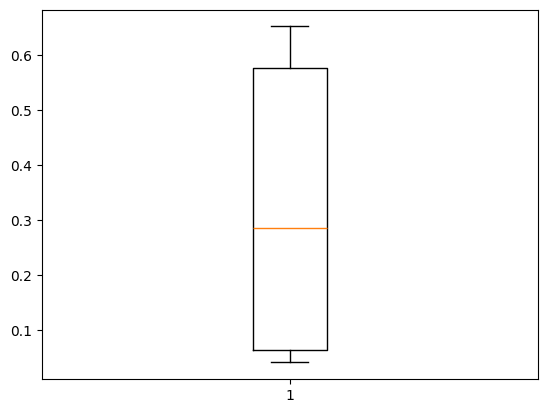

In [125]:
plt.boxplot(eval_metrics_trans1[0, :, :].flatten());

In [187]:
eval_metrics_trans1[:, :, 2]

array([[0.63802081, 0.7421875 , 0.5859375 , 0.64322919, 0.59375   ],
       [0.59635419, 0.70052081, 0.57552081, 0.68489581, 0.62760419],
       [0.6328125 , 0.77083331, 0.640625  , 0.62760419, 0.671875  ],
       [0.66666669, 0.62760419, 0.55208331, 0.61458331, 0.6171875 ],
       [0.70052081, 0.70572919, 0.70052081, 0.5546875 , 0.51041669]])

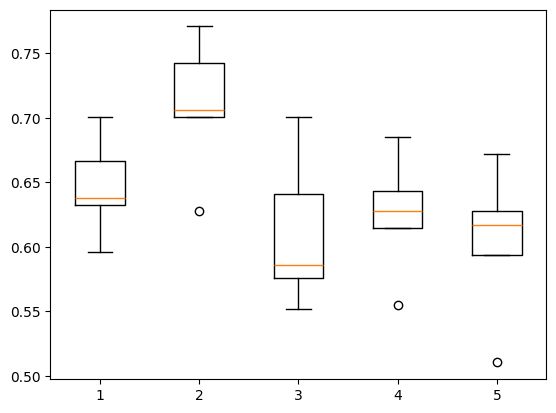

In [188]:
plt.boxplot(eval_metrics_trans1[:, :, 2]);

In [176]:
np.save('/home/tm/projects/Open_Close_GNN-1/aug/cv_results/ihb/tr1_3.npy', eval_metrics_trans1)

In [ ]:
gen_cl = np.concatenate([closed.numpy(), generated_series_cl])
gen_op = np.concatenate([opened.numpy(), generated_series_op])

fc_op = fc_calc(gen_op)
fc_cl = fc_calc(gen_cl)

full_dataset = OpenCloseDataset(datafolder='../data/', # dir where the processed files will be stored
                                open_file=fc_op, # data should be np.array of size (n_subjects, n_rois, n_rois)
                                close_file=fc_cl, # an array for closed and opened eyes
                                reload=True, # whether you want to reload already processed graphs
                                k_degree=7) # k degree

groups = np.concatenate([
            np.arange(opened.shape[0], dtype=int), 
            np.arange(opened.shape[0], opened.shape[0] + opened.shape[0], dtype=int), 
            np.arange(closed.shape[0], dtype=int), 
            np.arange(closed.shape[0], closed.shape[0] + closed.shape[0], dtype=int), 
            ])

labels = [full_dataset[i].y for i in range(len(full_dataset))]

eval_metrics_lstm_84 = np.zeros((5, 5, 3))
for en, rs in enumerate([73, 2, 5, 7, 0]):
    eval_metrics_lstm_84[en] = cv([32, 8], 20, 0.001, 0.2, 0.002, full_dataset, groups, labels, n_splits=5, rs=rs)

#np.save('/home/tm/projects/Open_Close_GNN-1/aug/cv_results/ihb/lstm_2.npy', eval_metrics_lstm_84)

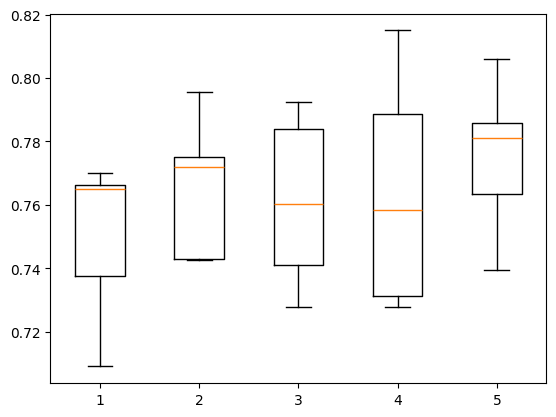

In [179]:
plt.boxplot(eval_metrics_lstm_84[:, :, 0]);

In [ ]:
fc_op = fc_calc(opened.numpy())
fc_cl = fc_calc(closed.numpy())

full_dataset = OpenCloseDataset(datafolder='../data/', # dir where the processed files will be stored
                                open_file=fc_op, # data should be np.array of size (n_subjects, n_rois, n_rois)
                                close_file=fc_cl, # an array for closed and opened eyes
                                reload=True, # whether you want to reload already processed graphs
                                k_degree=7) # k degree

groups = np.concatenate([
            np.arange(opened.shape[0], dtype=int), 
            np.arange(closed.shape[0], dtype=int)])

labels = [full_dataset[i].y for i in range(len(full_dataset))]

eval_metrics_real = np.zeros((5, 5, 3))
for en, rs in enumerate([73, 2, 5, 7, 0]):
    eval_metrics_real[en] = cv([32, 8], 20, 0.001, 0.2, 0.002, full_dataset, groups, labels, n_splits=5, rs=rs)

np.save('/home/tm/projects/Open_Close_GNN-1/aug/cv_results/ihb/real_3.npy', eval_metrics_real)

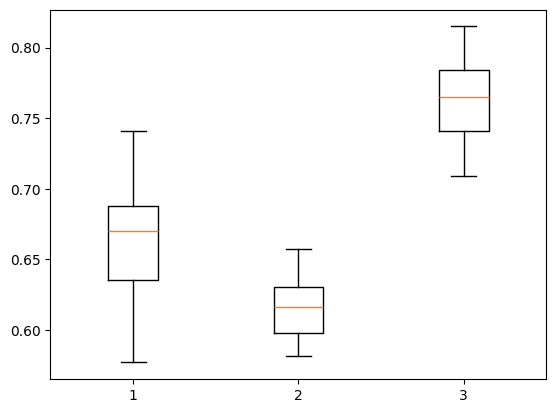

In [194]:
plt.boxplot([eval_metrics_real[:, :, 0].flatten(), eval_metrics_trans1[:, :, 0].flatten(), eval_metrics_lstm_84[:, :, 0].flatten()]);

In [56]:
aug_closed_5 = torch.load('/home/tm/projects/Open_Close_GNN-1/aug/gen_data/ihb/trans_cl_5.pt')
aug_opened_5 = torch.load('/home/tm/projects/Open_Close_GNN-1/aug/gen_data/ihb/trans_op_5.pt')


gen_tr_closed = torch.cat([closed, aug_closed_5])
gen_tr_opened = torch.cat([opened, aug_opened_5])

fc_cl = fc_calc(gen_tr_closed.numpy())
fc_op = fc_calc(gen_tr_opened.numpy())

full_dataset = OpenCloseDataset(datafolder='../data/', # dir where the processed files will be stored
                                open_file=fc_op, # data should be np.array of size (n_subjects, n_rois, n_rois)
                                close_file=fc_cl, # an array for closed and opened eyes
                                reload=True, # whether you want to reload already processed graphs
                                k_degree=7) # k degree

groups = np.concatenate([
            np.arange(opened.shape[0], dtype=int), 
            np.array([[i] * 5 for i in range(opened.shape[0], opened.shape[0] + opened.shape[0])]).flatten(), 
            np.arange(closed.shape[0], dtype=int), 
            np.array([[i] * 5 for i in range(closed.shape[0], closed.shape[0] + closed.shape[0])]).flatten()])

labels = [full_dataset[i].y for i in range(len(full_dataset))]

eval_metrics_trans5 = np.zeros((5, 5, 2))
for en, rs in enumerate([73]):#, 2, 5, 7, 0]):
    eval_metrics_trans5[en] = cv(20, 0.001, 0.2, full_dataset, groups, labels, n_splits=5, rs=rs)

#np.save('/home/tm/projects/Open_Close_GNN-1/aug/cv_results/ihb/tr5_2.npy', eval_metrics_trans5)

Processing...
Done!


0it [00:00, ?it/s]

========== 0 ==========
Epoch: 000, Train Loss: 0.6846, Test Loss 0.6994, Train Acc: 0.5054, Test Acc: 0.5006
Epoch: 005, Train Loss: 0.6798, Test Loss 1.1792, Train Acc: 0.5560, Test Acc: 0.5379
Epoch: 010, Train Loss: 0.4713, Test Loss 0.9241, Train Acc: 0.7206, Test Acc: 0.5603
Epoch: 015, Train Loss: 0.3879, Test Loss 0.7473, Train Acc: 0.8337, Test Acc: 0.5868
========== 1 ==========
Epoch: 000, Train Loss: 0.6916, Test Loss 0.7021, Train Acc: 0.5204, Test Acc: 0.5000
Epoch: 005, Train Loss: 0.5676, Test Loss 0.6762, Train Acc: 0.7228, Test Acc: 0.6040
Epoch: 010, Train Loss: 0.5776, Test Loss 0.9252, Train Acc: 0.6223, Test Acc: 0.5612
Epoch: 015, Train Loss: 0.4512, Test Loss 0.7352, Train Acc: 0.7527, Test Acc: 0.5723
========== 2 ==========
Epoch: 000, Train Loss: 0.6877, Test Loss 0.6935, Train Acc: 0.5110, Test Acc: 0.4913
Epoch: 005, Train Loss: 0.5495, Test Loss 0.6875, Train Acc: 0.6997, Test Acc: 0.5616
Epoch: 010, Train Loss: 0.3858, Test Loss 0.6900, Train Acc: 0.9196,

In [57]:
aug_closed_3 = torch.load('/home/tm/projects/Open_Close_GNN-1/aug/gen_data/ihb/trans_cl_3.pt')
aug_opened_3 = torch.load('/home/tm/projects/Open_Close_GNN-1/aug/gen_data/ihb/trans_op_3.pt')

gen_tr_closed = torch.cat([closed, aug_closed_3])
gen_tr_opened = torch.cat([opened, aug_opened_3])

fc_cl = fc_calc(gen_tr_closed.numpy())
fc_op = fc_calc(gen_tr_opened.numpy())

full_dataset = OpenCloseDataset(datafolder='../data/', # dir where the processed files will be stored
                                open_file=fc_op, # data should be np.array of size (n_subjects, n_rois, n_rois)
                                close_file=fc_cl, # an array for closed and opened eyes
                                reload=True, # whether you want to reload already processed graphs
                                k_degree=7) # k degree

groups = np.concatenate([
            np.arange(opened.shape[0], dtype=int), 
            np.array([[i] * 3 for i in range(opened.shape[0], opened.shape[0] + opened.shape[0])]).flatten(), 
            np.arange(closed.shape[0], dtype=int), 
            np.array([[i] * 3 for i in range(closed.shape[0], closed.shape[0] + closed.shape[0])]).flatten()])

labels = [full_dataset[i].y for i in range(len(full_dataset))]

eval_metrics_trans3 = np.zeros((5, 5, 2))
for en, rs in enumerate([73]):#, 2, 5, 7, 0]):
    eval_metrics_trans3[en] = cv(20, 0.001, 0.2, full_dataset, groups, labels, n_splits=5, rs=rs)



#np.save('/home/tm/projects/Open_Close_GNN-1/aug/cv_results/ihb/tr3_2.npy', eval_metrics_trans3)

Processing...
Done!


0it [00:00, ?it/s]

========== 0 ==========
Epoch: 000, Train Loss: 0.6852, Test Loss 0.6951, Train Acc: 0.6211, Test Acc: 0.5003
Epoch: 005, Train Loss: 0.6005, Test Loss 0.7699, Train Acc: 0.5566, Test Acc: 0.5576
Epoch: 010, Train Loss: 0.5601, Test Loss 0.8557, Train Acc: 0.5898, Test Acc: 0.5437
Epoch: 015, Train Loss: 0.6231, Test Loss 1.1520, Train Acc: 0.5859, Test Acc: 0.5625
========== 1 ==========
Epoch: 000, Train Loss: 0.6852, Test Loss 0.6907, Train Acc: 0.5852, Test Acc: 0.5134
Epoch: 005, Train Loss: 0.8214, Test Loss 0.8609, Train Acc: 0.5042, Test Acc: 0.5286
Epoch: 010, Train Loss: 0.3163, Test Loss 0.7761, Train Acc: 0.9574, Test Acc: 0.5196
Epoch: 015, Train Loss: 0.3302, Test Loss 0.7083, Train Acc: 0.9159, Test Acc: 0.5357
========== 2 ==========
Epoch: 000, Train Loss: 0.6985, Test Loss 0.7042, Train Acc: 0.4974, Test Acc: 0.5000
Epoch: 005, Train Loss: 0.5181, Test Loss 0.6697, Train Acc: 0.8511, Test Acc: 0.5612
Epoch: 010, Train Loss: 0.3440, Test Loss 0.7055, Train Acc: 0.9141,

In [58]:
aug_closed_10 = torch.load('/home/tm/projects/Open_Close_GNN-1/aug/gen_data/ihb/trans_cl_10.pt')
aug_opened_10 = torch.load('/home/tm/projects/Open_Close_GNN-1/aug/gen_data/ihb/trans_op_10.pt')

gen_tr_closed = torch.cat([closed, aug_closed_10])
gen_tr_opened = torch.cat([opened, aug_opened_10])

fc_cl = fc_calc(gen_tr_closed.numpy())
fc_op = fc_calc(gen_tr_opened.numpy())

full_dataset = OpenCloseDataset(datafolder='../data/', # dir where the processed files will be stored
                                open_file=fc_op, # data should be np.array of size (n_subjects, n_rois, n_rois)
                                close_file=fc_cl, # an array for closed and opened eyes
                                reload=False, # whether you want to reload already processed graphs
                                k_degree=7) # k degree

groups = np.concatenate([
            np.arange(opened.shape[0], dtype=int), 
            np.array([[i] * 10 for i in range(opened.shape[0], opened.shape[0] + opened.shape[0])]).flatten(), 
            np.arange(closed.shape[0], dtype=int), 
            np.array([[i] * 10 for i in range(closed.shape[0], closed.shape[0] + closed.shape[0])]).flatten()])

labels = [full_dataset[i].y for i in range(len(full_dataset))]

eval_metrics_trans10 = np.zeros((5, 5, 2))
for en, rs in enumerate([73]):#, 2, 5, 7, 0]):
    eval_metrics_trans10[en] = cv(20, 0.001, 0.2, full_dataset, groups, labels, n_splits=5, rs=rs)

#np.save('/home/tm/projects/Open_Close_GNN-1/aug/cv_results/ihb/tr10_2.npy', eval_metrics_trans10)

Processing...
Done!


0it [00:00, ?it/s]

========== 0 ==========
Epoch: 000, Train Loss: 0.6611, Test Loss 0.6869, Train Acc: 0.7018, Test Acc: 0.5243
Epoch: 005, Train Loss: 0.4020, Test Loss 0.7709, Train Acc: 0.8852, Test Acc: 0.5336
Epoch: 010, Train Loss: 0.5388, Test Loss 0.9427, Train Acc: 0.6453, Test Acc: 0.5408
Epoch: 015, Train Loss: 0.5128, Test Loss 0.7782, Train Acc: 0.6880, Test Acc: 0.5163
========== 1 ==========
Epoch: 000, Train Loss: 0.6759, Test Loss 0.6847, Train Acc: 0.6646, Test Acc: 0.5781
Epoch: 005, Train Loss: 0.4012, Test Loss 0.6775, Train Acc: 0.8887, Test Acc: 0.5503
Epoch: 010, Train Loss: 0.4331, Test Loss 0.7146, Train Acc: 0.8689, Test Acc: 0.5278
Epoch: 015, Train Loss: 0.4250, Test Loss 0.7114, Train Acc: 0.8765, Test Acc: 0.5017
========== 2 ==========
Epoch: 000, Train Loss: 0.6852, Test Loss 0.7089, Train Acc: 0.5026, Test Acc: 0.4967
Epoch: 005, Train Loss: 0.3328, Test Loss 0.6923, Train Acc: 0.9554, Test Acc: 0.5862
Epoch: 010, Train Loss: 0.4455, Test Loss 0.7658, Train Acc: 0.7761,

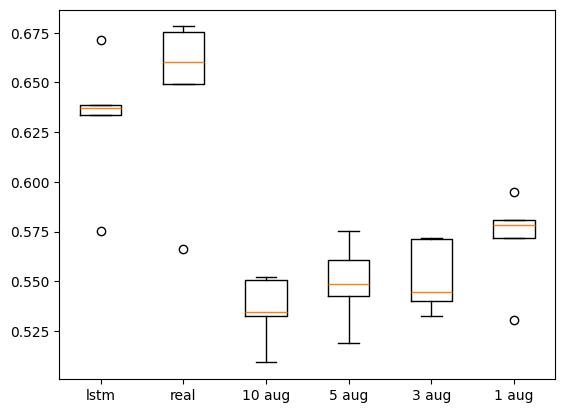

In [88]:
plt.boxplot([eval_metrics_lstm_84[0, :, 0], eval_metrics_real[0, :, 0], 
             eval_metrics_trans10[0, :, 0], eval_metrics_trans5[0, :, 0], 
             eval_metrics_trans3[0, :, 0], eval_metrics_trans1[0, :, 0]], 
             labels=['lstm', 'real', '10 aug', '5 aug', '3 aug', '1 aug']);

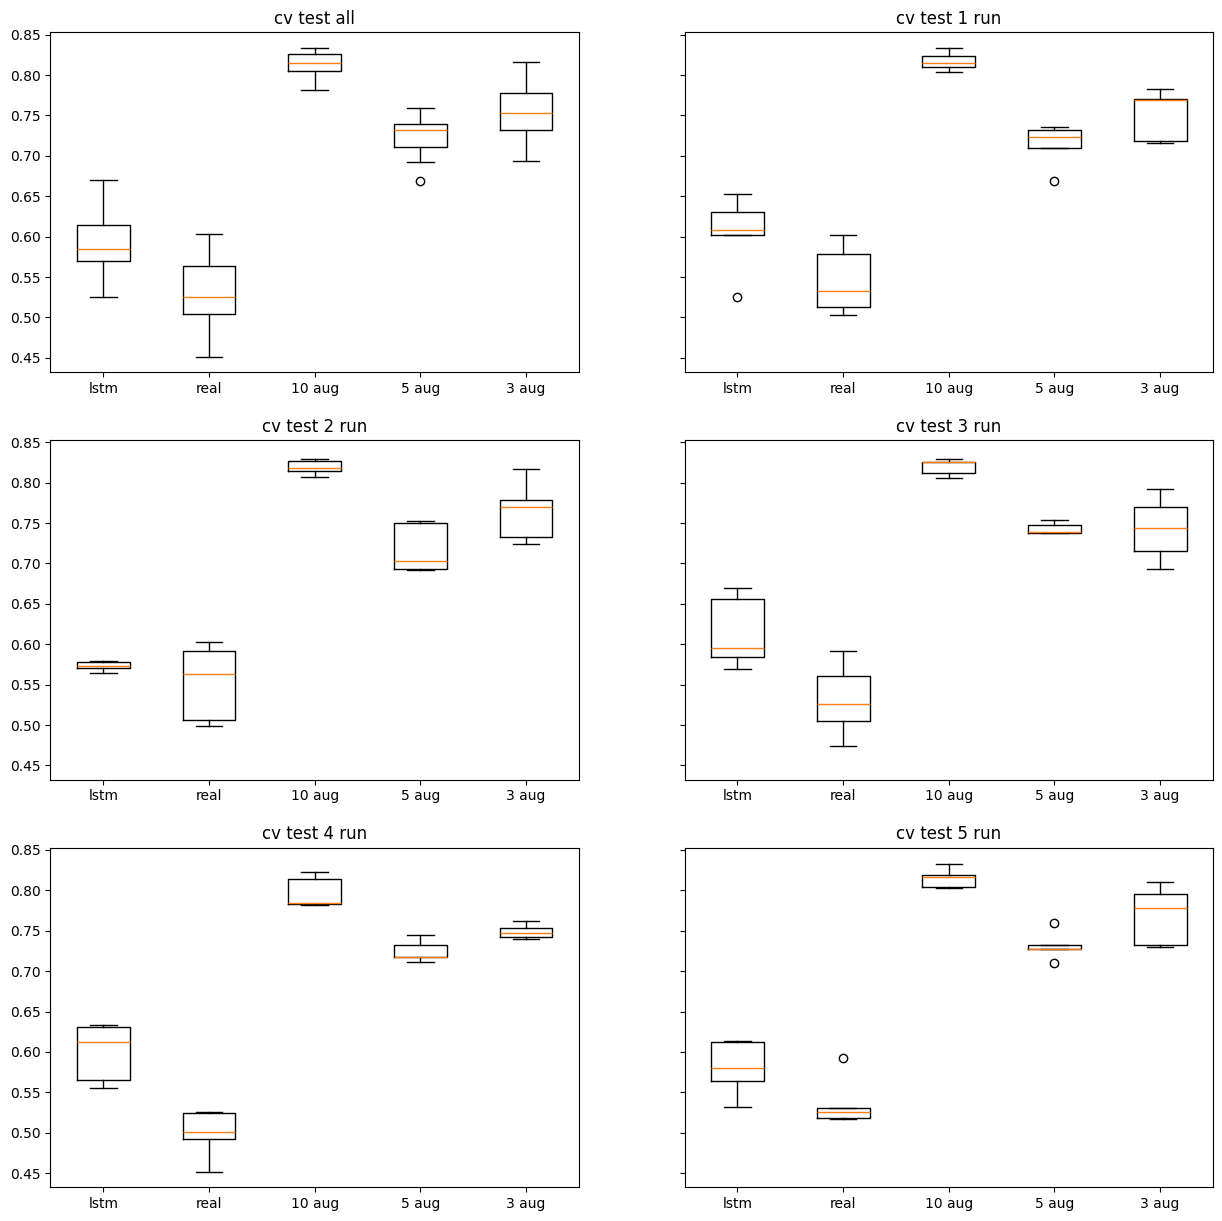

In [104]:

fig, ax = plt.subplots(3, 2, figsize=(15, 15), sharey='all')
ax = ax.flatten()
ax[0].boxplot([eval_metrics_lstm_84[:, :, 0].flatten(), eval_metrics_real[:, :, 0].flatten(), 
             eval_metrics_trans10[:, :, 0].flatten(), eval_metrics_trans5[:, :, 0].flatten(), 
             eval_metrics_trans3[:, :, 0].flatten()], 
             labels=['lstm', 'real', '10 aug', '5 aug', '3 aug'])

ax[0].set_title('cv test all')

for i in range(5):
    ax[i+1].boxplot([eval_metrics_lstm_84[i, :, 0], eval_metrics_real[i, :, 0], 
                    eval_metrics_trans10[i, :, 0], eval_metrics_trans5[i, :, 0], 
                    eval_metrics_trans3[i, :, 0]], 
                    labels=['lstm', 'real', '10 aug', '5 aug', '3 aug'])
    ax[i+1].set_title(f'cv test {i+1} run')
